In [204]:
import scipy.io
import numpy as np
from sklearn import preprocessing 
import pandas as pd
from numpy import mean
from numpy import std
#loading data from mat file 
datamat = scipy.io.loadmat('/content/drive/My Drive/dataset_BCIcomp1.mat')
#check the datatype of 'data'

type(datamat)

dict

In [205]:
!pip install wyrm

In [206]:

data = datamat['x_train'].astype('double')
#print shape of data
print (data.shape)
#for interchanging dimensions of data to required dimensions
data = data.swapaxes(0, 1)
print(data.shape)
data = data.swapaxes(0, 2)
print(data.shape)
labels = datamat['y_train'].astype('int').ravel()


(1152, 3, 140)
(3, 1152, 140)
(140, 1152, 3)


In [207]:
# Converting train data into wyrm Data Format
from wyrm import processing as proc

from wyrm.types import Data
#Wyrm Data has 3 attributes : 1.axes 2.names 3.units
#initialize the first attribute (Axes: desrcibe the number of dimension of data)
axes = [np.arange(i) for i in data.shape]
#assigning 140 labels to axes[0]
axes[0] = labels
axes[2] = [str(i) for i in range(data.shape[2])]
#initialize 2nd and 3rd attribute (NAME: Describe the name of each dimension of data UNITS: the units of those dimensions)
names = ['Class', 'Time', 'Channel']
units = ['#', 'ms', '#']
dat_train = Data(data=data, axes=axes, names=names, units=units)
#the EEG was sampled with 128 Hz
dat_train.fs = 128
#We have two classes 
dat_train.class_names = ['left', 'right']
#Converting multi-class to 0s and 1s for binary classification
dat_train.axes[0][dat_train.axes[0] == 2] = 0
dat_train=proc.sort_channels(dat_train)


In [208]:
# Converting test data into wyrm Data Format

data = datamat['x_test'].astype('double')
print (data.shape)
data = data.swapaxes(0, 1)
print(data.shape)
data = data.swapaxes(0, 2)
print(data.shape)


axes = [np.arange(i) for i in data.shape]

axes[2] = [str(i) for i in range(data.shape[2])]
names = ['Class', 'Time', 'Channel']
units = ['#', 'ms', '#']
dat_test = Data(data=data, axes=axes, names=names, units=units)
dat_test.fs = 128
dat_test.class_names = ['left', 'right']


(1152, 3, 140)
(3, 1152, 140)
(140, 1152, 3)


In [209]:
dat_test=proc.sort_channels(dat_test)

In [210]:
# Load labels for test data 
labels=scipy.io.loadmat('/content/drive/My Drive/COVID-19/labels_data_set_iii.mat')
print(type(labels))
y_test=labels['y_test'].astype('int')
#converting in to 0s and 1s
y_test[y_test == 2] = 0


<class 'dict'>


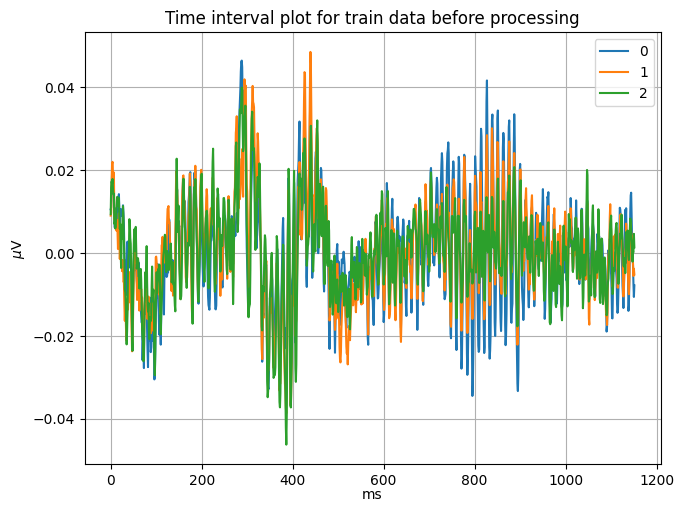

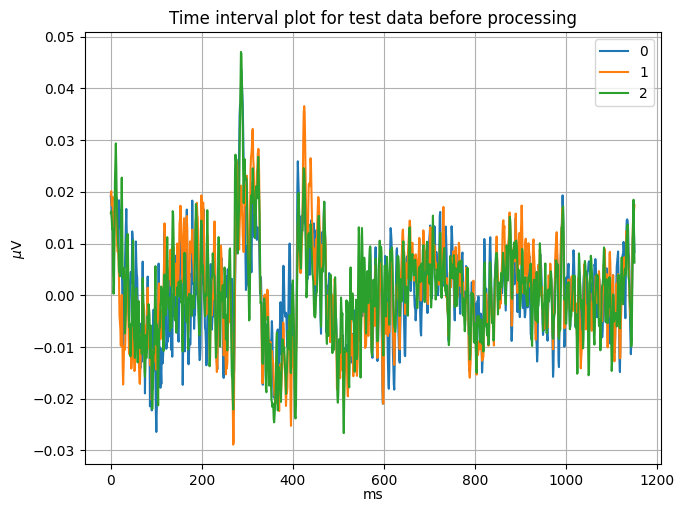

In [211]:
import matplotlib.pyplot as plt
from wyrm import plot as pt
pt.plot_timeinterval(dat_train)
plt.title("Time interval plot for train data before processing")
plt.savefig('/content/drive/My Drive/COVID-19/Train_before_Process.png', dpi=900, format= "png", bbox_inches="tight")
pt.plot_timeinterval(dat_test)
plt.title("Time interval plot for test data before processing")  
plt.savefig('/content/drive/My Drive/COVID-19/Test_before_Process.png', dpi=900, format= "png", bbox_inches="tight")

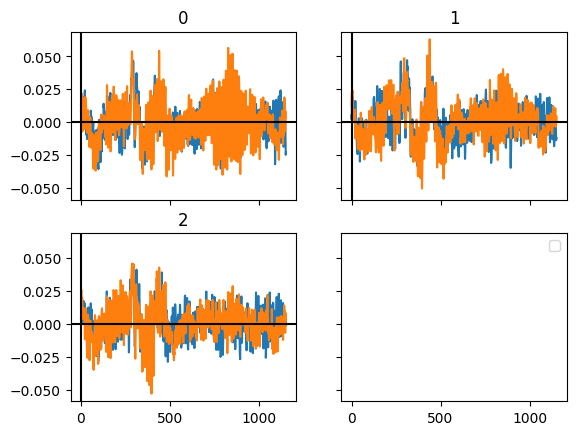

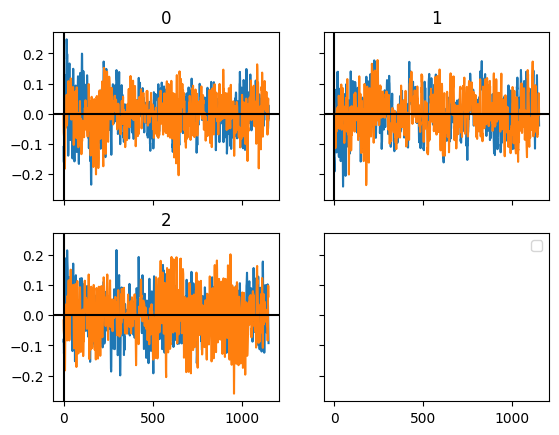

In [212]:
# Class Average for each channel
pt.plot_channels(dat_train,2)
plt.savefig('/content/drive/My Drive/COVID-19/train_Class_average.png', dpi=600, format= "png", bbox_inches="tight")
pt.plot_channels(dat_test,2)
plt.savefig('/content/drive/My Drive/COVID-19/Test_class_average.png', dpi=600, format= "png", bbox_inches="tight")

## Pre-process

In [213]:
#@title Default title text
from scipy import fftpack
def preproc(dat_train,dat_test):
  fsm=dat_train.fs/2
  # filtering the data with 0.9 Hz high and 15 Hz low filter to reduce noise
  #Applying butterworth filters accompanied low pass and high pass filter
  c,a=proc.signal.butter(8,[15/fsm],btype='low')
  dat_train=proc.lfilter(dat_train,c,a)
  c,a=proc.signal.butter(8,0.9/fsm,btype='high')
  dat_train=proc.lfilter(dat_train,c,a)
  c,a=proc.signal.butter(8,[15/fsm],btype='low')
  dat_test=proc.lfilter(dat_test,c,a)
  c,a=proc.signal.butter(8,0.9/fsm,btype='high')
  dat_test=proc.lfilter(dat_test,c,a)
  
  
  dat_train = proc.subsample(dat_train, 16,1)
  dat_test = proc.subsample(dat_test, 16,1)
  
  pt.plot_timeinterval(dat_train)
  plt.title("Time interval plot for train data after filtering and subsampling")
  plt.savefig('/content/drive/My Drive/COVID-19/Train_After_Process.png', dpi=900, format= "png", bbox_inches="tight")

  pt.plot_timeinterval(dat_test)
  plt.title("Time interval plot for test data after filtering and subsampling")
  plt.savefig('/content/drive/My Drive/COVID-19/Test_After_Process.png', dpi=900, format= "png", bbox_inches="tight")
  #applying common spatial pattern
  filt, pattern, _ = proc.calculate_csp(dat_train)
  dat_train = proc.apply_csp(dat_train, filt)
  dat_test = proc.apply_csp(dat_test, filt)
  dat_train = proc.variance(dat_train,1)
  dat_train = proc.logarithm(dat_train)
  
  dat_test = proc.variance(dat_test,1)
  dat_test = proc.logarithm(dat_test)
  dat_train = proc.rectify_channels(dat_train)
  dat_test = proc.rectify_channels(dat_test)
  
  dat_train = proc.square(dat_train)
  dat_test = proc.square(dat_test)
  
  pt.plot_timeinterval(dat_train)
  plt.title("Time interval plot for train data after CSP filter")
  pt.plot_timeinterval(dat_test)
  plt.title("Time interval plot for test data after CSP filter")
  return dat_train,dat_test


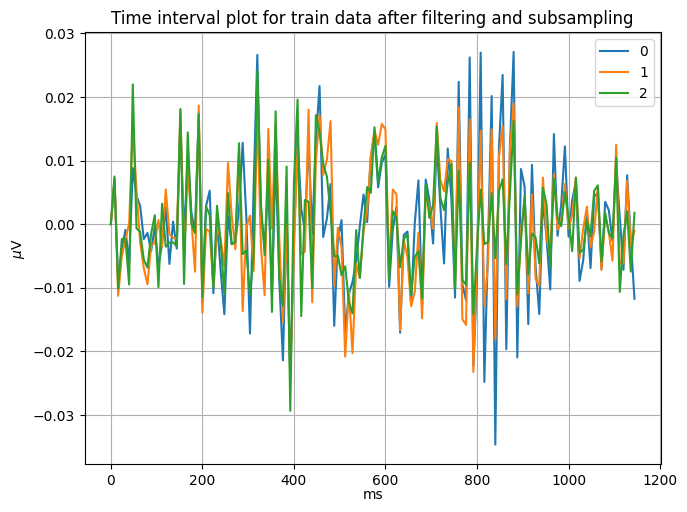

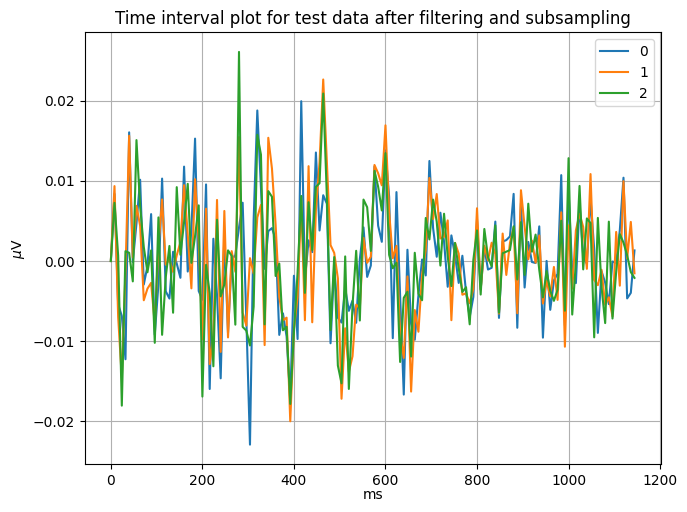

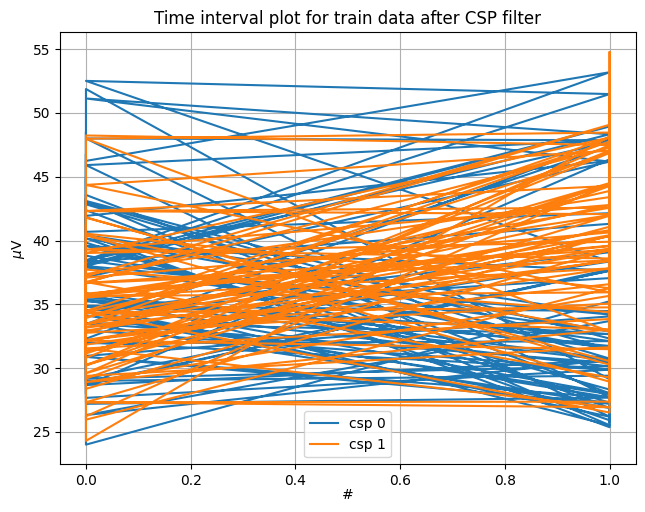

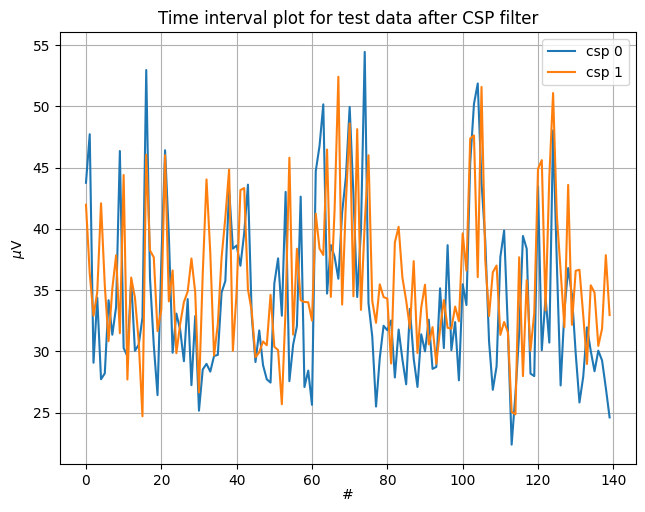

In [214]:
fvtr,fvte=preproc(dat_train,dat_test)


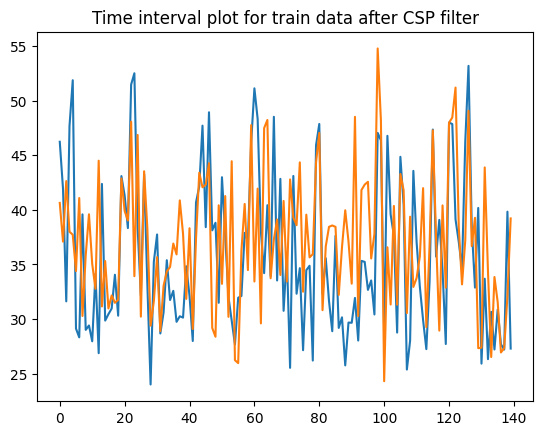

In [215]:
plt.plot(fvtr.data) #CSP for label 0 and 1 in train data
#plt.show
plt.title("Time interval plot for train data after CSP filter")
plt.savefig('/content/drive/My Drive/COVID-19/Train_After_CSP.png', dpi=600, format= "png", bbox_inches="tight")



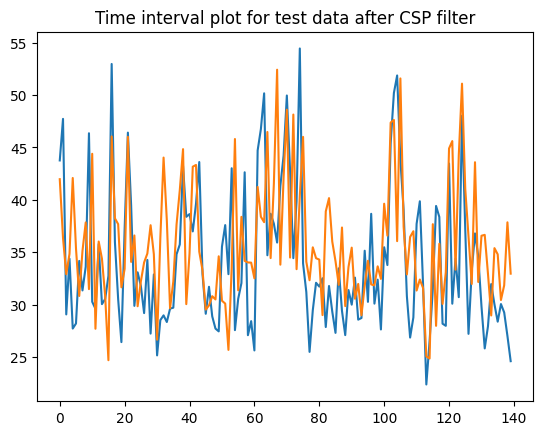

In [216]:
plt.plot(fvte.data) #CSP for label 0 and 1 in test data
plt.title("Time interval plot for test data after CSP filter")
plt.savefig('/content/drive/My Drive/COVID-19/Test_After_CSP.png', dpi=600, format= "png", bbox_inches="tight")



## LDA Classifier

In [217]:
cfy=proc.lda_train(fvtr)
result=proc.lda_apply(fvte,cfy)
result1=(np.sign(result)+1)/2



In [218]:
sum=0.0
for i in range(len(result1)):
	if result1[i]==y_test[i]:
		sum=sum+1
lda_acc=sum/(len(result))
print  (lda_acc)


0.7928571428571428


In [219]:
# Creating a function to report confusion metrics
def confusion_metrics (conf_matrix):
# save confusion matrix and slice into four pieces
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    print('True Positives:', TP)
    print('True Negatives:', TN)
    print('False Positives:', FP)
    print('False Negatives:', FN)
    # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    
    # calculate mis-classification
    conf_misclassification = 1- conf_accuracy
    
    # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))
    
    # calculate precision
    conf_precision = (TP / float(TP + FP))
    # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
    print('-'*50)
    print(f'Accuracy: {round(conf_accuracy,2)}') 
    print(f'Mis-Classification: {round(conf_misclassification,2)}') 
    print(f'Sensitivity: {round(conf_sensitivity,2)}') 
    print(f'Specificity: {round(conf_specificity,2)}') 
    print(f'Precision: {round(conf_precision,2)}')
    print(f'f_1 Score: {round(conf_f1,2)}')

In [220]:
from sklearn import metrics
# Creating the confusion matrix
cm = metrics.confusion_matrix(y_test, result1)


In [221]:
cmdf = pd.DataFrame(cm, 
            columns = ['Predicted Negative', 'Predicted Positive'],
            index = ['Actual Negative', 'Actual Positive'])
cmdf

,Predicted Negative,Predicted Positive
Actual Negative,57,13
Actual Positive,16,54


In [222]:
confusion_metrics(cm)

True Positives: 54
True Negatives: 57
False Positives: 13
False Negatives: 16
--------------------------------------------------
Accuracy: 0.79
Mis-Classification: 0.21
Sensitivity: 0.77
Specificity: 0.81
Precision: 0.81
f_1 Score: 0.79


In [223]:
from sklearn.metrics import matthews_corrcoef
lda_mcc= matthews_corrcoef(y_test,result1)
lda_mcc

0.5862529287108078

#### Train Labels

In [224]:
labelstr=datamat['y_train'].astype('int').ravel()
y_tr=labelstr
y_tr[y_tr == 2] = 0


### Random Forest Classifier


In [225]:
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param={
'max_depth':[5,10,20,50,100],

'n_estimators':[2,10,25,50,100]
}

first_xgb = RandomForestClassifier()
clf =GridSearchCV(first_xgb,param, cv=5,verbose=2)
clf.fit(fvtr.data,y_tr)
print(clf.best_params_)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] max_depth=5, n_estimators=2 .....................................
[CV] ...................... max_depth=5, n_estimators=2, total=   0.0s
[CV] max_depth=5, n_estimators=2 .....................................
[CV] ...................... max_depth=5, n_estimators=2, total=   0.0s
[CV] max_depth=5, n_estimators=2 .....................................
[CV] ...................... max_depth=5, n_estimators=2, total=   0.0s
[CV] max_depth=5, n_estimators=2 .....................................
[CV] ...................... max_depth=5, n_estimators=2, total=   0.0s
[CV] max_depth=5, n_estimators=2 .....................................
[CV] ...................... max_depth=5, n_estimators=2, total=   0.0s
[CV] max_depth=5, n_estimators=10 ....................................
[CV] ..................... max_depth=5, n_estimators=10, total=   0.0s
[CV] max_depth=5, n_estimators=10 ....................................
[CV] ..........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ..................... max_depth=5, n_estimators=25, total=   0.0s
[CV] max_depth=5, n_estimators=25 ....................................
[CV] ..................... max_depth=5, n_estimators=25, total=   0.0s
[CV] max_depth=5, n_estimators=25 ....................................
[CV] ..................... max_depth=5, n_estimators=25, total=   0.0s
[CV] max_depth=5, n_estimators=50 ....................................
[CV] ..................... max_depth=5, n_estimators=50, total=   0.1s
[CV] max_depth=5, n_estimators=50 ....................................
[CV] ..................... max_depth=5, n_estimators=50, total=   0.1s
[CV] max_depth=5, n_estimators=50 ....................................
[CV] ..................... max_depth=5, n_estimators=50, total=   0.1s
[CV] max_depth=5, n_estimators=50 ....................................
[CV] ..................... max_depth=5, n_estimators=50, total=   0.1s
[CV] max_depth=5, n_estimators=50 ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    7.0s finished


In [226]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,roc_curve,roc_auc_score, precision_score, recall_score
rf = RandomForestClassifier(max_depth = 5, n_estimators=50,n_jobs=1)
rf.fit(fvtr.data, y_tr)
rf_predict= rf.predict(fvte.data)
#rf_probs=rf.predict_proba(xte12)[:,1]
rf_acc=accuracy_score(y_test,rf_predict)
rf_mcc= matthews_corrcoef(y_test,rf_predict)
rf_mcc

0.5151274263289282

In [227]:
from sklearn import metrics
# Creating the confusion matrix
cm = metrics.confusion_matrix(y_test, rf_predict)


In [228]:
cmdf = pd.DataFrame(cm, 
            columns = ['Predicted Negative', 'Predicted Positive'],
            index = ['Actual Negative', 'Actual Positive'])
cmdf

,Predicted Negative,Predicted Positive
Actual Negative,55,15
Actual Positive,19,51


In [229]:
confusion_metrics(cm)

True Positives: 51
True Negatives: 55
False Positives: 15
False Negatives: 19
--------------------------------------------------
Accuracy: 0.76
Mis-Classification: 0.24
Sensitivity: 0.73
Specificity: 0.79
Precision: 0.77
f_1 Score: 0.75


## XGBoost Classifier

In [230]:
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

param={
'min_child_weight':[5,10,15],
'max_depth':[5,10,20,50,100],
'learning_rate':[0.001,0.05,0.5,1],
'subsample':[0.8,0.5,0.2],
'n_estimators':[2,10,25,50,100]
}

first_xgb = xgb.XGBClassifier()
clf =GridSearchCV(first_xgb,param, cv=5,verbose=2)
clf.fit(fvtr.data,y_tr)
print(clf.best_params_)


Fitting 5 folds for each of 900 candidates, totalling 4500 fits
[CV] learning_rate=0.001, max_depth=5, min_child_weight=5, n_estimators=2, subsample=0.8 
[CV]  learning_rate=0.001, max_depth=5, min_child_weight=5, n_estimators=2, subsample=0.8, total=   0.0s
[CV] learning_rate=0.001, max_depth=5, min_child_weight=5, n_estimators=2, subsample=0.8 
[CV]  learning_rate=0.001, max_depth=5, min_child_weight=5, n_estimators=2, subsample=0.8, total=   0.0s
[CV] learning_rate=0.001, max_depth=5, min_child_weight=5, n_estimators=2, subsample=0.8 
[CV]  learning_rate=0.001, max_depth=5, min_child_weight=5, n_estimators=2, subsample=0.8, total=   0.0s
[CV] learning_rate=0.001, max_depth=5, min_child_weight=5, n_estimators=2, subsample=0.8 
[CV]  learning_rate=0.001, max_depth=5, min_child_weight=5, n_estimators=2, subsample=0.8, total=   0.0s
[CV] learning_rate=0.001, max_depth=5, min_child_weight=5, n_estimators=2, subsample=0.8 
[CV]  learning_rate=0.001, max_depth=5, min_child_weight=5, n_esti

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Streaming output truncated to the last 5000 lines.
[CV] learning_rate=0.05, max_depth=50, min_child_weight=15, n_estimators=50, subsample=0.5 
[CV]  learning_rate=0.05, max_depth=50, min_child_weight=15, n_estimators=50, subsample=0.5, total=   0.0s
[CV] learning_rate=0.05, max_depth=50, min_child_weight=15, n_estimators=50, subsample=0.5 
[CV]  learning_rate=0.05, max_depth=50, min_child_weight=15, n_estimators=50, subsample=0.5, total=   0.0s
[CV] learning_rate=0.05, max_depth=50, min_child_weight=15, n_estimators=50, subsample=0.5 
[CV]  learning_rate=0.05, max_depth=50, min_child_weight=15, n_estimators=50, subsample=0.5, total=   0.0s
[CV] learning_rate=0.05, max_depth=50, min_child_weight=15, n_estimators=50, subsample=0.5 
[CV]  learning_rate=0.05, max_depth=50, min_child_weight=15, n_estimators=50, subsample=0.5, total=   0.0s
[CV] learning_rate=0.05, max_depth=50, min_child_weight=15, n_estimators=50, subsample=0.2 
[CV]  learning_rate=0.05, max_depth=50, min_child_weight=15, 

[Parallel(n_jobs=1)]: Done 4500 out of 4500 | elapsed:   41.0s finished


In [231]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,roc_curve,roc_auc_score, precision_score, recall_score
xg = xgb.XGBClassifier(max_depth = 5, n_estimators=25,n_jobs=1,learning_rate=0.05,min_child_weight=5,subsample=0.8)
xg.fit(fvtr.data, y_tr)
xg_predict= xg.predict(fvte.data)
xg_acc=accuracy_score(y_test,xg_predict)
xg_mcc= matthews_corrcoef(y_test,xg_predict)
xg_mcc


0.4402254531628119

In [232]:
from sklearn import metrics
# Creating the confusion matrix
cm = metrics.confusion_matrix(y_test, xg_predict)


In [233]:
cmdf = pd.DataFrame(cm, 
            columns = ['Predicted Negative', 'Predicted Positive'],
            index = ['Actual Negative', 'Actual Positive'])
cmdf

,Predicted Negative,Predicted Positive
Actual Negative,42,28
Actual Positive,12,58


In [234]:
confusion_metrics(cm)

True Positives: 58
True Negatives: 42
False Positives: 28
False Negatives: 12
--------------------------------------------------
Accuracy: 0.71
Mis-Classification: 0.29
Sensitivity: 0.83
Specificity: 0.6
Precision: 0.67
f_1 Score: 0.74


## SVM

In [235]:
from sklearn.svm import SVC

param={
'C':[0.0001,0.001,0.01,0.1,1,10,100,1000]
}

svm = SVC()
clf =GridSearchCV(svm,param, cv=5,verbose=2)
clf.fit(fvtr.data,y_tr)
print(clf.best_params_)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] C=0.0001 ........................................................
[CV] ......................................... C=0.0001, total=   0.0s
[CV] C=0.0001 ........................................................
[CV] ......................................... C=0.0001, total=   0.0s
[CV] C=0.0001 ........................................................
[CV] ......................................... C=0.0001, total=   0.0s
[CV] C=0.0001 ........................................................
[CV] ......................................... C=0.0001, total=   0.0s
[CV] C=0.0001 ........................................................
[CV] ......................................... C=0.0001, total=   0.0s
[CV] C=0.001 .........................................................
[CV] .......................................... C=0.001, total=   0.0s
[CV] C=0.001 .........................................................
[CV] ............

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.2s finished


In [236]:
svm = SVC(C=0.0001, probability=True)
svm.fit(fvtr.data, y_tr)
svm_predict= svm.predict(fvte.data)
svm_acc=accuracy_score(y_test,svm_predict)
svm_mcc= matthews_corrcoef(y_test,svm_predict)
svm_mcc

0.4753740567999037

In [237]:
from sklearn import metrics
# Creating the confusion matrix
cm = metrics.confusion_matrix(y_test, svm_predict)
cmdf = pd.DataFrame(cm, 
            columns = ['Predicted Negative', 'Predicted Positive'],
            index = ['Actual Negative', 'Actual Positive'])
cmdf


,Predicted Negative,Predicted Positive
Actual Negative,47,23
Actual Positive,14,56


In [238]:
confusion_metrics(cm)

True Positives: 56
True Negatives: 47
False Positives: 23
False Negatives: 14
--------------------------------------------------
Accuracy: 0.74
Mis-Classification: 0.26
Sensitivity: 0.8
Specificity: 0.67
Precision: 0.71
f_1 Score: 0.75


## Logistic Regression

In [239]:
from sklearn.linear_model import LogisticRegression

param={
'C':[0.0001,0.001,0.01,0.1,1,10,100,1000]
}

lr = LogisticRegression()
clf =GridSearchCV(lr,param, cv=5,verbose=2)
clf.fit(fvtr.data,y_tr)
print(clf.best_params_)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] C=0.0001 ........................................................
[CV] ......................................... C=0.0001, total=   0.0s
[CV] C=0.0001 ........................................................
[CV] ......................................... C=0.0001, total=   0.0s
[CV] C=0.0001 ........................................................
[CV] ......................................... C=0.0001, total=   0.0s
[CV] C=0.0001 ........................................................
[CV] ......................................... C=0.0001, total=   0.0s
[CV] C=0.0001 ........................................................
[CV] ......................................... C=0.0001, total=   0.0s
[CV] C=0.001 .........................................................
[CV] .......................................... C=0.001, total=   0.0s
[CV] C=0.001 .........................................................
[CV] ............

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .......................................... C=0.001, total=   0.0s
[CV] C=0.001 .........................................................
[CV] .......................................... C=0.001, total=   0.0s
[CV] C=0.001 .........................................................
[CV] .......................................... C=0.001, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.4s finished


In [240]:
lr = LogisticRegression(C=0.00001)
lr.fit(fvtr.data, y_tr)
lr_predict= lr.predict(fvte.data)
lr_acc=accuracy_score(y_test,lr_predict)
lr_mcc= matthews_corrcoef(y_test,lr_predict)
lr_mcc

0.5576552248712563

In [241]:
from sklearn import metrics
# Creating the confusion matrix
cm = metrics.confusion_matrix(y_test, lr_predict)
cmdf = pd.DataFrame(cm, 
            columns = ['Predicted Negative', 'Predicted Positive'],
            index = ['Actual Negative', 'Actual Positive'])
cmdf


,Predicted Negative,Predicted Positive
Actual Negative,56,14
Actual Positive,17,53


In [242]:
confusion_metrics(cm)

True Positives: 53
True Negatives: 56
False Positives: 14
False Negatives: 17
--------------------------------------------------
Accuracy: 0.78
Mis-Classification: 0.22
Sensitivity: 0.76
Specificity: 0.8
Precision: 0.79
f_1 Score: 0.77


## KNeighbors Classifier

In [243]:
from sklearn.neighbors import KNeighborsClassifier
param={
'n_neighbors':[2,6,10,40,70,100]
}

kn = KNeighborsClassifier()
clf =GridSearchCV(kn,param, cv=5,verbose=2)
clf.fit(fvtr.data,y_tr)
print(clf.best_params_)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] n_neighbors=2 ...................................................
[CV] .................................... n_neighbors=2, total=   0.0s
[CV] n_neighbors=2 ...................................................
[CV] .................................... n_neighbors=2, total=   0.0s
[CV] n_neighbors=2 ...................................................
[CV] .................................... n_neighbors=2, total=   0.0s
[CV] n_neighbors=2 ...................................................
[CV] .................................... n_neighbors=2, total=   0.0s
[CV] n_neighbors=2 ...................................................
[CV] .................................... n_neighbors=2, total=   0.0s
[CV] n_neighbors=6 ...................................................
[CV] .................................... n_neighbors=6, total=   0.0s
[CV] n_neighbors=6 ...................................................
[CV] ............

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................................... n_neighbors=40, total=   0.0s
[CV] n_neighbors=70 ..................................................
[CV] ................................... n_neighbors=70, total=   0.0s
[CV] n_neighbors=70 ..................................................
[CV] ................................... n_neighbors=70, total=   0.0s
[CV] n_neighbors=70 ..................................................
[CV] ................................... n_neighbors=70, total=   0.0s
[CV] n_neighbors=70 ..................................................
[CV] ................................... n_neighbors=70, total=   0.0s
[CV] n_neighbors=70 ..................................................
[CV] ................................... n_neighbors=70, total=   0.0s
[CV] n_neighbors=100 .................................................
[CV] .................................. n_neighbors=100, total=   0.0s
[CV] n_neighbors=100 .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished


In [244]:
kn = KNeighborsClassifier(n_neighbors=10)
kn.fit(fvtr.data, y_tr)
kn_predict= kn.predict(fvte.data)
k_acc=accuracy_score(y_test,kn_predict)
kn_mcc= matthews_corrcoef(y_test,kn_predict)
kn_mcc

0.5041846056968675

In [245]:
from sklearn import metrics
# Creating the confusion matrix
cm = metrics.confusion_matrix(y_test, kn_predict)
cmdf = pd.DataFrame(cm, 
            columns = ['Predicted Negative', 'Predicted Positive'],
            index = ['Actual Negative', 'Actual Positive'])
cmdf


,Predicted Negative,Predicted Positive
Actual Negative,57,13
Actual Positive,22,48


In [246]:
confusion_metrics(cm)

True Positives: 48
True Negatives: 57
False Positives: 13
False Negatives: 22
--------------------------------------------------
Accuracy: 0.75
Mis-Classification: 0.25
Sensitivity: 0.69
Specificity: 0.81
Precision: 0.79
f_1 Score: 0.73


## Naive Bayes Classifier

In [247]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(fvtr.data, y_tr)
nb_predict= nb.predict(fvte.data)
nb_acc=accuracy_score(y_test,nb_predict)
nb_mcc= matthews_corrcoef(y_test,nb_predict)
nb_mcc

0.4270713489651562

In [248]:
from sklearn import metrics
# Creating the confusion matrix
cm = metrics.confusion_matrix(y_test, nb_predict)
cmdf = pd.DataFrame(cm, 
            columns = ['Predicted Negative', 'Predicted Positive'],
            index = ['Actual Negative', 'Actual Positive'])
cmdf


,Predicted Negative,Predicted Positive
Actual Negative,58,12
Actual Positive,29,41


In [249]:
confusion_metrics(cm)

True Positives: 41
True Negatives: 58
False Positives: 12
False Negatives: 29
--------------------------------------------------
Accuracy: 0.71
Mis-Classification: 0.29
Sensitivity: 0.59
Specificity: 0.83
Precision: 0.77
f_1 Score: 0.67


## Decision Tree Classifier

In [250]:
from sklearn.tree import DecisionTreeClassifier
param={
'max_depth':[2,6,10,40,70,100],
'min_samples_split':[5,10,100,500]
}

dt = DecisionTreeClassifier()
clf =GridSearchCV(dt,param, cv=5,verbose=2)
clf.fit(fvtr.data,y_tr)
print(clf.best_params_)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] max_depth=2, min_samples_split=5 ................................
[CV] ................. max_depth=2, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_split=5 ................................
[CV] ................. max_depth=2, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_split=5 ................................
[CV] ................. max_depth=2, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_split=5 ................................
[CV] ................. max_depth=2, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_split=5 ................................
[CV] ................. max_depth=2, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_split=10 ...............................
[CV] ................ max_depth=2, min_samples_split=10, total=   0.0s
[CV] max_depth=2, min_samples_split=10 ...............................
[CV] ..........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................ max_depth=2, min_samples_split=10, total=   0.0s
[CV] max_depth=2, min_samples_split=10 ...............................
[CV] ................ max_depth=2, min_samples_split=10, total=   0.0s
[CV] max_depth=2, min_samples_split=100 ..............................
[CV] ............... max_depth=2, min_samples_split=100, total=   0.0s
[CV] max_depth=2, min_samples_split=100 ..............................
[CV] ............... max_depth=2, min_samples_split=100, total=   0.0s
[CV] max_depth=2, min_samples_split=100 ..............................
[CV] ............... max_depth=2, min_samples_split=100, total=   0.0s
[CV] max_depth=2, min_samples_split=100 ..............................
[CV] ............... max_depth=2, min_samples_split=100, total=   0.0s
[CV] max_depth=2, min_samples_split=100 ..............................
[CV] ............... max_depth=2, min_samples_split=100, total=   0.0s
[CV] max_depth=2, min_samples_split=500 ..............................
[CV] .

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.3s finished


In [251]:
from sklearn.naive_bayes import GaussianNB
dt = DecisionTreeClassifier(max_depth=2,min_samples_split=5)
dt.fit(fvtr.data, y_tr)
dt_predict= dt.predict(fvte.data)
dt_acc=accuracy_score(y_test,dt_predict)
dt_mcc= matthews_corrcoef(y_test,dt_predict)
dt_mcc

0.4241380059937358

In [252]:
from sklearn import metrics
# Creating the confusion matrix
cm = metrics.confusion_matrix(y_test, dt_predict)
cmdf = pd.DataFrame(cm, 
            columns = ['Predicted Negative', 'Predicted Positive'],
            index = ['Actual Negative', 'Actual Positive'])
cmdf


,Predicted Negative,Predicted Positive
Actual Negative,42,28
Actual Positive,13,57


In [253]:
confusion_metrics(cm)

True Positives: 57
True Negatives: 42
False Positives: 28
False Negatives: 13
--------------------------------------------------
Accuracy: 0.71
Mis-Classification: 0.29
Sensitivity: 0.81
Specificity: 0.6
Precision: 0.67
f_1 Score: 0.74


## Model Comparison

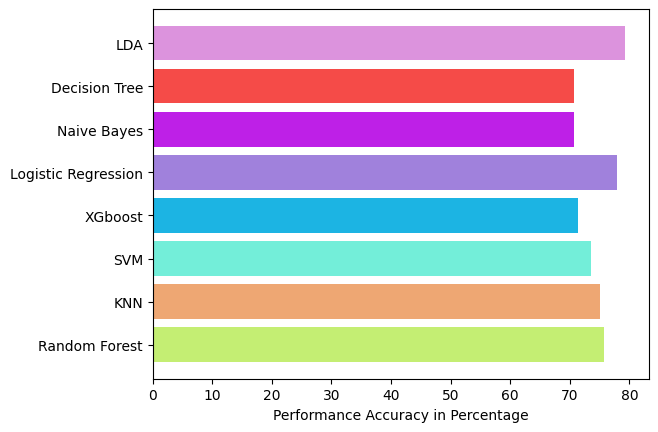

In [254]:
X_bar = ['Random Forest','KNN','SVM','XGboost','Logistic Regression','Naive Bayes','Decision Tree','LDA']
Y_bar= [rf_acc*100,k_acc*100,svm_acc*100,xg_acc*100,lr_acc*100,nb_acc*100,dt_acc*100,lda_acc*100]
import matplotlib.pyplot as plt
plt.barh(X_bar, Y_bar, align='center', color=('#C4EE73','#EEA773', '#73EED9', '#1CB4E3', '#A081DC', '#BE20E7', '#F54B48','#DC93DD'))
plt.xlabel("Performance Accuracy in Percentage")
#plt.show()
plt.savefig('/content/drive/My Drive/COVID-19/Comparison.png', dpi=600, format= "png", bbox_inches="tight")
                      

### Ensemble Bagging

In [255]:
from sklearn.ensemble import BaggingClassifier
b_classifier = BaggingClassifier()
param={
'base_estimator':[None, SVC()],
'n_estimators':[2,5,10,20,30,40],
}

clf =GridSearchCV(b_classifier,param, cv=5,verbose=2)
clf.fit(fvtr.data,y_tr)
print(clf.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] base_estimator=None, n_estimators=2 .............................
[CV] .............. base_estimator=None, n_estimators=2, total=   0.0s
[CV] base_estimator=None, n_estimators=2 .............................
[CV] .............. base_estimator=None, n_estimators=2, total=   0.0s
[CV] base_estimator=None, n_estimators=2 .............................
[CV] .............. base_estimator=None, n_estimators=2, total=   0.0s
[CV] base_estimator=None, n_estimators=2 .............................
[CV] .............. base_estimator=None, n_estimators=2, total=   0.0s
[CV] base_estimator=None, n_estimators=2 .............................
[CV] .............. base_estimator=None, n_estimators=2, total=   0.0s
[CV] base_estimator=None, n_estimators=5 .............................
[CV] .............. base_estimator=None, n_estimators=5, total=   0.0s
[CV] base_estimator=None, n_estimators=5 .............................
[CV] ...........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ............. base_estimator=None, n_estimators=20, total=   0.0s
[CV] base_estimator=None, n_estimators=20 ............................
[CV] ............. base_estimator=None, n_estimators=20, total=   0.0s
[CV] base_estimator=None, n_estimators=20 ............................
[CV] ............. base_estimator=None, n_estimators=20, total=   0.0s
[CV] base_estimator=None, n_estimators=20 ............................
[CV] ............. base_estimator=None, n_estimators=20, total=   0.0s
[CV] base_estimator=None, n_estimators=20 ............................
[CV] ............. base_estimator=None, n_estimators=20, total=   0.0s
[CV] base_estimator=None, n_estimators=30 ............................
[CV] ............. base_estimator=None, n_estimators=30, total=   0.0s
[CV] base_estimator=None, n_estimators=30 ............................
[CV] ............. base_estimator=None, n_estimators=30, total=   0.1s
[CV] base_estimator=None, n_estimators=30 ............................
[CV] .

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    1.9s finished


In [256]:
b_classifier=BaggingClassifier(base_estimator=SVC(),n_estimators=10)
b_classifier.fit(fvtr.data, y_tr)
b_predict= b_classifier.predict(fvte.data)
b_acc=accuracy_score(y_test,b_predict)
b_mcc= matthews_corrcoef(y_test,b_predict)
b_mcc

0.5329951545938314

In [257]:
from sklearn import metrics
# Creating the confusion matrix
cm = metrics.confusion_matrix(y_test, b_predict)
cmdf = pd.DataFrame(cm, 
            columns = ['Predicted Negative', 'Predicted Positive'],
            index = ['Actual Negative', 'Actual Positive'])
cmdf

,Predicted Negative,Predicted Positive
Actual Negative,58,12
Actual Positive,21,49


In [258]:
confusion_metrics(cm)

True Positives: 49
True Negatives: 58
False Positives: 12
False Negatives: 21
--------------------------------------------------
Accuracy: 0.76
Mis-Classification: 0.24
Sensitivity: 0.7
Specificity: 0.83
Precision: 0.8
f_1 Score: 0.75


### Ensemble Boosting

In [259]:
from sklearn.ensemble import AdaBoostClassifier
ada_classifier = AdaBoostClassifier()
param={
'n_estimators':[2,5,10,20,30,40],
'learning_rate':[1.0,2.0,3.0,4.0],
}

clf =GridSearchCV(ada_classifier,param, cv=5,verbose=2)
clf.fit(fvtr.data,y_tr)
print(clf.best_params_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] learning_rate=1.0, n_estimators=2 ...............................
[CV] ................ learning_rate=1.0, n_estimators=2, total=   0.0s
[CV] learning_rate=1.0, n_estimators=2 ...............................
[CV] ................ learning_rate=1.0, n_estimators=2, total=   0.0s
[CV] learning_rate=1.0, n_estimators=2 ...............................
[CV] ................ learning_rate=1.0, n_estimators=2, total=   0.0s
[CV] learning_rate=1.0, n_estimators=2 ...............................
[CV] ................ learning_rate=1.0, n_estimators=2, total=   0.0s
[CV] learning_rate=1.0, n_estimators=2 ...............................
[CV] ................ learning_rate=1.0, n_estimators=2, total=   0.0s
[CV] learning_rate=1.0, n_estimators=5 ...............................
[CV] ................ learning_rate=1.0, n_estimators=5, total=   0.0s
[CV] learning_rate=1.0, n_estimators=5 ...............................
[CV] ..........

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    3.5s finished


In [260]:
ada_classifier=AdaBoostClassifier(learning_rate=1.0,n_estimators=2,random_state=42)
ada_classifier.fit(fvtr.data, y_tr)
ada_predict= b_classifier.predict(fvte.data)
ada_acc=accuracy_score(y_test,ada_predict)
ada_mcc= matthews_corrcoef(y_test,ada_predict)
ada_mcc

0.5329951545938314

In [261]:
from sklearn import metrics
# Creating the confusion matrix
cm = metrics.confusion_matrix(y_test, ada_predict)
cmdf = pd.DataFrame(cm, 
            columns = ['Predicted Negative', 'Predicted Positive'],
            index = ['Actual Negative', 'Actual Positive'])
cmdf


,Predicted Negative,Predicted Positive
Actual Negative,58,12
Actual Positive,21,49


In [262]:
confusion_metrics(cm)

True Positives: 49
True Negatives: 58
False Positives: 12
False Negatives: 21
--------------------------------------------------
Accuracy: 0.76
Mis-Classification: 0.24
Sensitivity: 0.7
Specificity: 0.83
Precision: 0.8
f_1 Score: 0.75


### Ensemble Stacking

In [263]:
from sklearn.ensemble import StackingClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.calibration import CalibratedClassifierCV
#models = [('LDA',LinearDiscriminantAnalysis(),'ada',AdaBoostClassifier(learning_rate=1.0,n_estimators=2)),('lr',LogisticRegression(C=0.0001))]
#models = [('LDA',LinearDiscriminantAnalysis(),'bag',BaggingClassifier(base_estimator=SVC(),n_estimators=10),'ada',AdaBoostClassifier(learning_rate=1.0,n_estimators=2)),('lr',LogisticRegression(C=0.0001))]
#models = [('LR',LogisticRegression(),'ada',AdaBoostClassifier(learning_rate=1.0,n_estimators=2),'SVC',SVC(C=0.0001),'gb',GaussianNB,'dt',DecisionTreeClassifier(max_depth=2,min_samples_split=5)),('LDA',LinearDiscriminantAnalysis())]
#s_classifier = StackingClassifier(estimators=models)
kn = KNeighborsClassifier(n_neighbors=10)
kn.fit(fvtr.data, y_tr)

svm = SVC(C=0.0001, probability=True)
svm.fit(fvtr.data, y_tr)

lda= LinearDiscriminantAnalysis()
lda.fit(fvtr.data,y_tr)

sig1 = CalibratedClassifierCV(lda )
sig2 = CalibratedClassifierCV(ada_classifier)
sig3 = CalibratedClassifierCV(kn)
sig4 = CalibratedClassifierCV(rf)
sig5 = CalibratedClassifierCV(lr)

sclf = StackingClassifier(classifiers=[sig1, sig2, sig3, sig4, sig5 ], meta_classifier= LogisticRegression(C=0.001), use_probas= True, use_features_in_secondary= True)
sclf.fit(fvtr.data, y_tr)  
sc_predict= sclf.predict(fvte.data)
sc_acc=accuracy_score(y_test,sc_predict)
sc_mcc= matthews_corrcoef(y_test,sc_predict)
sc_mcc

0.6009819973837496

In [264]:
from sklearn import metrics
# Creating the confusion matrix
cm = metrics.confusion_matrix(y_test, sc_predict)
cmdf = pd.DataFrame(cm, 
            columns = ['Predicted Negative', 'Predicted Positive'],
            index = ['Actual Negative', 'Actual Positive'])
cmdf

,Predicted Negative,Predicted Positive
Actual Negative,58,12
Actual Positive,16,54


In [265]:
confusion_metrics(cm)

True Positives: 54
True Negatives: 58
False Positives: 12
False Negatives: 16
--------------------------------------------------
Accuracy: 0.8
Mis-Classification: 0.2
Sensitivity: 0.77
Specificity: 0.83
Precision: 0.82
f_1 Score: 0.79


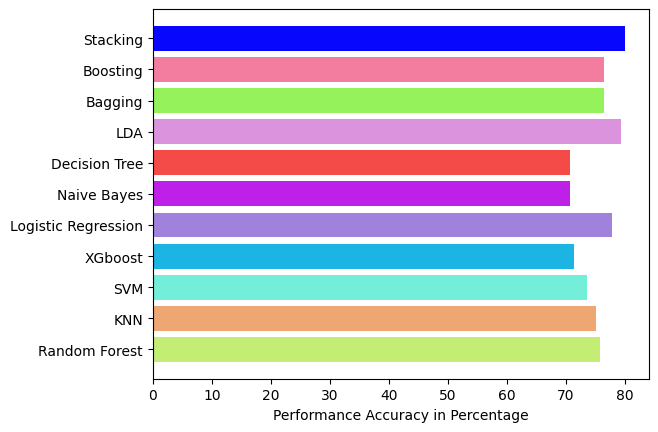

In [266]:
X_bar = ['Random Forest','KNN','SVM','XGboost','Logistic Regression','Naive Bayes','Decision Tree','LDA','Bagging','Boosting','Stacking']
Y_bar= [rf_acc*100,k_acc*100,svm_acc*100,xg_acc*100,lr_acc*100,nb_acc*100,dt_acc*100,lda_acc*100,b_acc*100,ada_acc*100,sc_acc*100 ]
import matplotlib.pyplot as plt
plt.barh(X_bar, Y_bar, align='center', color=('#C4EE73','#EEA773', '#73EED9', '#1CB4E3', '#A081DC', '#BE20E7', '#F54B48','#DC93DD','#96F25A','#F37D9F','#0807FE'))
plt.xlabel("Performance Accuracy in Percentage")
#plt.show()
plt.savefig('/content/drive/My Drive/COVID-19/Final_Comparison.png', dpi=600, format= "png", bbox_inches="tight")

In [267]:
from sklearn.metrics import matthews_corrcoef, roc_curve, roc_auc_score

In [268]:
lda_probs = lda.predict_proba(fvte.data)[:, 1]
rf_probs =rf.predict_proba(fvte.data)[:, 1]
xg_probs = xg.predict_proba(fvte.data)[:, 1]
svm_probs = svm.predict_proba(fvte.data)[:, 1]
lr_probs = lr.predict_proba(fvte.data)[:, 1]
kn_probs = kn.predict_proba(fvte.data)[:, 1]
nb_probs = nb.predict_proba(fvte.data)[:, 1]
dt_probs = dt.predict_proba(fvte.data)[:, 1]
bag_probs = b_classifier.predict_proba(fvte.data)[:, 1]
ada_probs=ada_classifier.predict_proba(fvte.data)[:, 1]
stack_probs= sclf.predict_proba(fvte.data)[:, 1]

In [269]:
lda_auc = roc_auc_score(y_test, lda_probs)
rf_auc = roc_auc_score(y_test, rf_probs)
xg_auc = roc_auc_score(y_test, xg_probs)
svm_auc = roc_auc_score(y_test, svm_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
kn_auc = roc_auc_score(y_test, kn_probs)
nb_auc = roc_auc_score(y_test, nb_probs)
dt_auc = roc_auc_score(y_test, dt_probs)
bag_auc = roc_auc_score(y_test, bag_probs)
ada_auc = roc_auc_score(y_test, ada_probs)
stack_auc = roc_auc_score(y_test, stack_probs)

In [270]:
lda_fpr, lda_tpr, _ = roc_curve(y_test, lda_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
xg_fpr, xg_tpr, _ = roc_curve(y_test, xg_probs)
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
kn_fpr, kn_tpr, _ = roc_curve(y_test, kn_probs)
nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_probs)
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_probs)
bag_fpr, bag_tpr, _ = roc_curve(y_test, bag_probs)
ada_fpr, ada_tpr, _ = roc_curve(y_test, ada_probs)
stack_fpr, stack_tpr, _ = roc_curve(y_test, stack_probs)

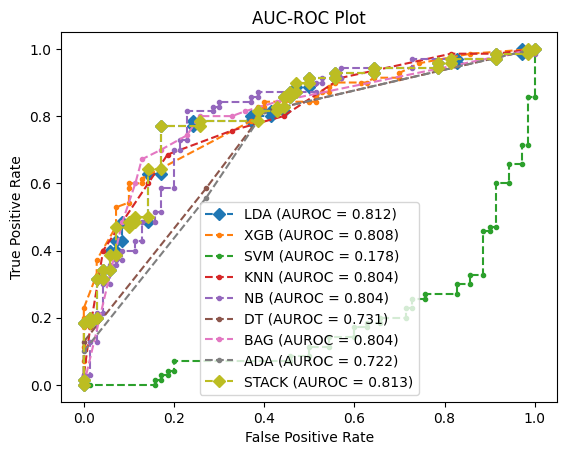

In [282]:
plt.plot(lda_fpr, lda_tpr, marker='D', linestyle='--', label='LDA (AUROC = %0.3f)' % lda_auc)
#plt.plot(rf_fpr, rf_tpr, marker='.', linestyle='--', label='RF (AUROC = %0.3f)' % rf_auc)
plt.plot(xg_fpr, xg_tpr, marker='.', linestyle='--', label='XGB (AUROC = %0.3f)' % xg_auc)
plt.plot(svm_fpr, svm_tpr, marker='.', linestyle='--', label='SVM (AUROC = %0.3f)' % svm_auc)
#plt.plot(lr_fpr, lr_tpr, marker='.', linestyle='--', label='LR (AUROC = %0.3f)' % lr_auc)
plt.plot(kn_fpr, kn_tpr, marker='.', linestyle='--', label='KNN (AUROC = %0.3f)' % kn_auc)
plt.plot(nb_fpr, nb_tpr, marker='.', linestyle='--', label='NB (AUROC = %0.3f)' % nb_auc)
plt.plot(dt_fpr, dt_tpr, marker='.', linestyle='--', label='DT (AUROC = %0.3f)' % dt_auc)
plt.plot(bag_fpr, bag_tpr, marker='.', linestyle='--', label='BAG (AUROC = %0.3f)' % bag_auc)
plt.plot(ada_fpr, ada_tpr, marker='.', linestyle='--', label='ADA (AUROC = %0.3f)' % ada_auc)
plt.plot(stack_fpr, stack_tpr, marker='D', linestyle='--', label='STACK (AUROC = %0.3f)' % stack_auc)
plt.title('AUC-ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('/content/drive/My Drive/COVID-19/ROCplot_comparison.png', format='png', dpi=300)

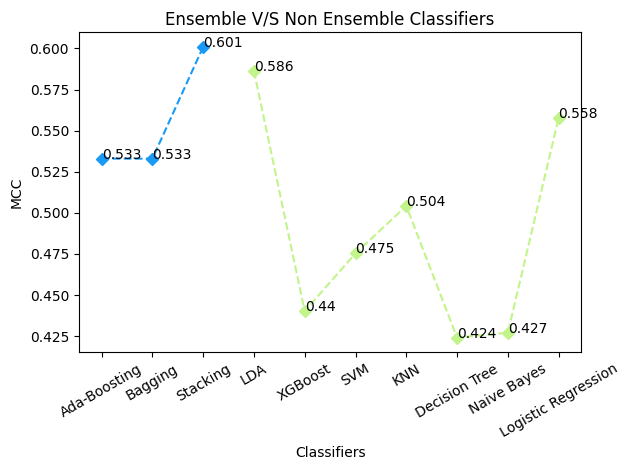

In [272]:
#Plotting MCC bar graph of Ensemble V/S Non-Ensemble Classifiers
ensemble_classifiers = ['Ada-Boosting', 'Bagging', 'Stacking']
non_ensemble_classifiers = ['LDA','XGBoost','SVM','KNN', 'Decision Tree','Naive Bayes','Logistic Regression']
ensemble_mcc = [ada_mcc, b_mcc, sc_mcc]
non_ensemble_mcc = [lda_mcc, xg_mcc, svm_mcc,kn_mcc, dt_mcc, nb_mcc, lr_mcc]
plt.plot(ensemble_classifiers, ensemble_mcc, marker='D',linestyle= '--', color='#189AF6')
for i,j in zip(ensemble_classifiers,ensemble_mcc):
  plt.annotate(round(j, 3),xy=(i,j))
plt.plot(non_ensemble_classifiers, non_ensemble_mcc, marker='D', linestyle= '--', color='#C2F48B')
for i,j in zip(non_ensemble_classifiers,non_ensemble_mcc):
  plt.annotate(round(j, 3),xy=(i,j))
plt.xlabel('Classifiers')
plt.xticks(rotation=30)
plt.ylabel('MCC')
plt.title('Ensemble V/S Non Ensemble Classifiers')
plt.tight_layout()
plt.savefig('/content/drive/My Drive/COVID-19/MCC_comparison.png', format='png', dpi=300)
